1. Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.

2. Модифицировать решение первого задания путем добавления 𝐿2 -регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

3. [опция]. Модернизировать решение задания 2, заменив L2 регуляризацию на L1 регуляризацию.

In [256]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

%matplotlib inline

In [257]:
# сгенерируем набор данных
X, y, coef = datasets.make_regression(n_samples=10000, n_features = 2, n_informative = 2, n_targets = 1, effective_rank = None,
                                              noise = 5, coef = True, random_state = 2)


In [258]:
X.shape, y.shape, coef

((10000, 2), (10000,), array([47.46102593,  1.66486956]))

In [259]:
X

array([[-2.75161769e-01,  3.88051923e-01],
       [-7.39931870e-01,  6.41540019e-01],
       [ 1.73259956e+00,  1.38746003e+00],
       ...,
       [ 9.95690738e-02,  1.14050425e+00],
       [ 5.72821025e-01, -1.62061166e-03],
       [-8.10975181e-01, -7.90286210e-01]])

In [260]:
# Вопрос нужно ли добавлять единичный столбец? В методичке нам обьясняют без него, Вы с ним, как все-таки нужно делать?
X_with_ones = np.hstack((np.ones((X.shape[0], 1)), X))

In [261]:
X_with_ones

array([[ 1.00000000e+00, -2.75161769e-01,  3.88051923e-01],
       [ 1.00000000e+00, -7.39931870e-01,  6.41540019e-01],
       [ 1.00000000e+00,  1.73259956e+00,  1.38746003e+00],
       ...,
       [ 1.00000000e+00,  9.95690738e-02,  1.14050425e+00],
       [ 1.00000000e+00,  5.72821025e-01, -1.62061166e-03],
       [ 1.00000000e+00, -8.10975181e-01, -7.90286210e-01]])

In [262]:
X_with_ones = X_with_ones.T

Отмасштабируем получившиеся признаки методом стандартизации и Robust scale

In [263]:
def calc_std_feat(x: np.array):
        res = (x - x.mean()) / x.std()
        return res

In [264]:
def standartization_data (X):
    X_st = X.copy().astype(np.float64)
    for i in range(X.shape[0]):
        if i == 0:
          continue
        X_st[i] = calc_std_feat(X[i])
    return X_st
X_stand = standartization_data(X_with_ones)
X_stand

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [-2.77754356e-01, -7.44773351e-01,  1.73972197e+00, ...,
         9.87897050e-02,  5.74331592e-01, -8.16160421e-01],
       [ 3.85504659e-01,  6.35711699e-01,  1.37197680e+00, ...,
         1.12821753e+00,  8.75901031e-04, -7.77581502e-01]])

In [265]:
# проверка: среднее значение должно быть равно нулю, стандартная ошибка - единице
np.mean(X_stand[1]), np.std(X_stand[1])

(-1.1368683772161604e-17, 1.0)

In [266]:
def robust_scale(X):
    X_rob = X.copy().astype(np.float64)
    for i in range(X.shape[0]):
        if i == 0:
          continue
        percentiles = np.percentile(X[i], (25.0, 75.0))
        X_rob[i] = (X[i] - np.median(X[i])) / percentiles[1] - percentiles[0]
    return X_rob
X_rob = robust_scale(X_with_ones)
X_rob  

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.26124802, -0.44198395,  3.29914124, ...,  0.82824384,
         1.54430948, -0.5494778 ],
       [ 1.25482063,  1.63081558,  2.73722713, ...,  2.37092147,
         0.67682542, -0.49298999]])

Далее реализуем градиентный спуск обычный и стохастический градиентный спуск.

In [267]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

In [270]:
def gradient_descent_alpha_div_i(X, y, start_alpha, epsilon):
    n = X.shape[1]
    W = np.random.randn(X.shape[0])
    i=1
    W_prev = np.array([])
    err_prev = 0
    err = 0
    errors = []
    while True:
        W_prev = W.copy()
        err_prev = err
        y_pred = np.dot(W, X)
        err = calc_mse(y, y_pred)
        # W_start = W.copy()
        W -= start_alpha/i * (1/n * 2 * np.dot(X, (y_pred - y)))
        errors.append(err)
        if i % 10 == 0:
            print(i, start_alpha/i, W, err)
        if np.sum(np.abs(W - W_prev)) < epsilon:
            break
        i+=1
    print(f"для заданной точности {epsilon}\nоптимальное количество итераций = {i-1}\nпри них получаем W = {W_prev} и mse = {err_prev}")
    return W_prev, errors

In [271]:
W, errors = gradient_descent_alpha_div_i(X_stand, y, 1, 0.00001)

10 0.1 [1.05877443e-02 4.72533403e+01 1.64196452e+00] 25.17494603816963
20 0.05 [1.05877443e-02 4.72530107e+01 1.65201936e+00] 25.17468668257522
30 0.03333333333333333 [1.05877443e-02 4.72529217e+01 1.65377812e+00] 25.174676757578737
40 0.025 [1.05877443e-02 4.72528851e+01 1.65438174e+00] 25.174675256298777
50 0.02 [1.05877443e-02 4.72528664e+01 1.65465834e+00] 25.174674867234955
60 0.016666666666666666 [1.05877443e-02 4.72528554e+01 1.65480768e+00] 25.17467473185895
для заданной точности 1e-05
оптимальное количество итераций = 64
при них получаем W = [1.05877443e-02 4.72528523e+01 1.65484865e+00] и mse = 25.17467470364971


Text(0, 0.5, 'MSE')

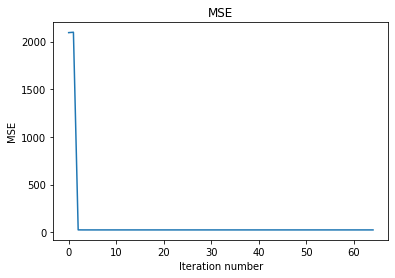

In [272]:
# Визуализируем изменение функционала ошибки
plt.plot(range(len(errors)), errors)
plt.title('MSE')
plt.xlabel('Iteration number')
plt.ylabel('MSE')

In [273]:
def gradient_descent(X: np.array, 
                     y: np.array,
                     n_iters: int = 1000,
                     alpha: float = 0.01,  
                     epsilon: float = 1e-5):
    n = X.shape[1]
    W = np.random.randn(X.shape[0])
    errors, weights = [], [W]
    i=1
    W_prev = np.array([])
    err_prev = 0
    err = 0
    for n_iter in range(n_iters):
    #while True:
        W_prev = W.copy()
        err_prev = err
        y_pred = np.dot(W, X)
        err = calc_mse(y, y_pred)
        W -= alpha * (1/n * 2 * np.dot(X, (y_pred - y)))
        errors.append(err)
        weights.append(W)
        if np.abs(err - err_prev) < epsilon:
            break
        #i+=1
    print(f"для заданной точности {epsilon}\nполучаем W = {W_prev} и mse = {err_prev}")
    return W_prev, errors, weights

In [274]:
W, errors, weights = gradient_descent(X_stand, y, 1000, 0.01, 0.00001)

для заданной точности 1e-05
получаем W = [1.01861552e-02 4.72374879e+01 1.65602690e+00] и mse = 25.174920146667677


Text(0, 0.5, 'MSE')

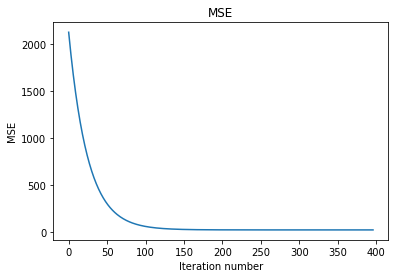

In [275]:
# Визуализируем изменение функционала ошибки
plt.plot(range(len(errors)), errors)
plt.title('MSE')
plt.xlabel('Iteration number')
plt.ylabel('MSE')

In [276]:
# стохастический градиентный спуск 
def sgd_gradient_descent(X, y, iterations, qty_in_batch=64, alpha=1e-2):
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    n_batch = n // qty_in_batch
    if n % qty_in_batch != 0:
        n_batch += 1
    errs = []
    for i in range(1, iterations+1):
        for b in range(n_batch):
            start_ = qty_in_batch*b
            end_ = qty_in_batch*(b+1)
        
            X_tmp = X[:, start_ : end_]
            y_tmp = y[start_ : end_]
            y_pred_tmp = np.dot(W, X_tmp)
            W -= (alpha * (1/n * 2 * np.dot((y_pred_tmp - y_tmp), X_tmp.T)))
        errs.append(calc_mse(y_tmp, y_pred_tmp))
    y_pred = np.dot(W, X_stand)
    mse_ = (sum((y - y_pred)**2)) / len(y)
    return W, mse_, errs

In [277]:
W, mse_, errs = sgd_gradient_descent(X_stand, y, 1000, qty_in_batch=64, alpha=1e-2)

In [278]:
mse_

25.174675077476344

Text(0, 0.5, 'MSE')

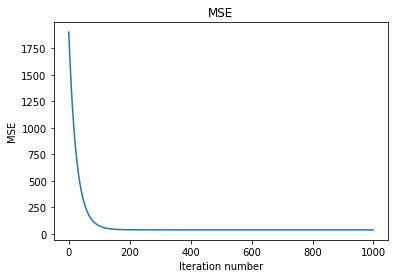

In [279]:
# Визуализируем изменение функционала ошибки
plt.plot(range(len(errs)), errs)
plt.title('MSE')
plt.xlabel('Iteration number')
plt.ylabel('MSE')

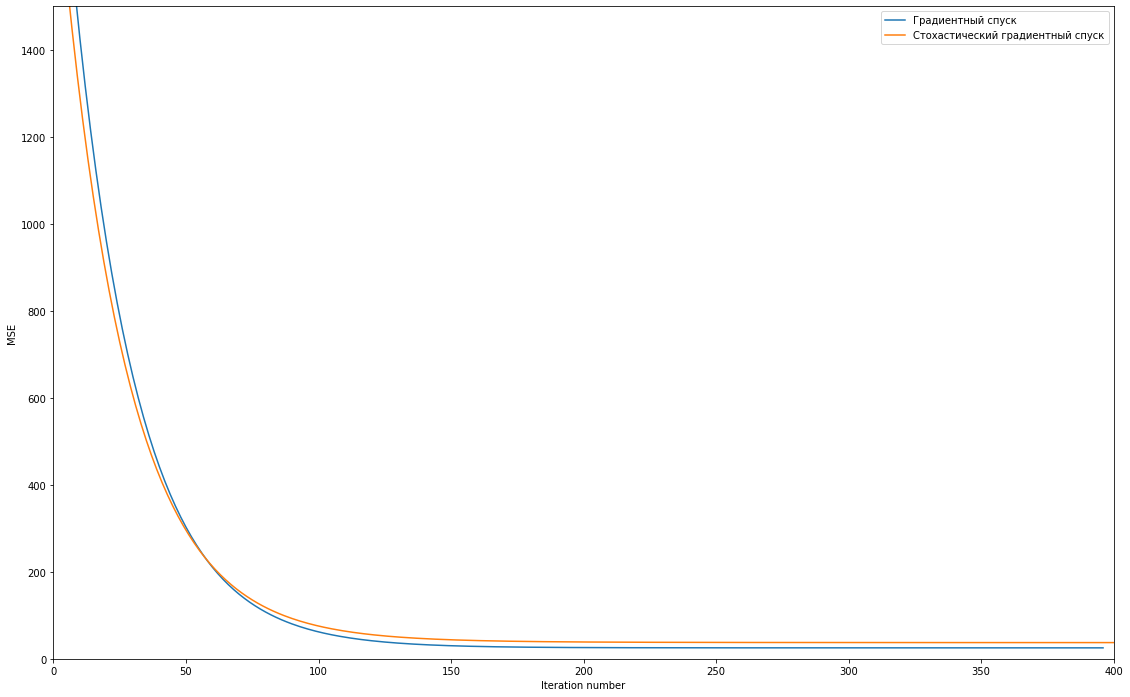

In [280]:
plt.figure(figsize=(19, 12))
plt.plot(range(len(errors)), errors, label="Градиентный спуск")
plt.plot(range(len(errs)), errs, label="Стохастический градиентный спуск")
plt.axis([0, 400, 0, 1500])
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.legend()
plt.show()

Стохастический спуск сходится быстрее, но незначительно

# Регуляризация

2. Модифицировать решение первого задания путем добавления 𝐿2 -регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

3. [опция]. Модернизировать решение задания 2, заменив L2 регуляризацию на L1 регуляризацию.

# L2 регуляризация - Ridge

f(x, W) + (lambda_/2) * np.sum(W**2)

df/dw1 = d(w1**2 + w2**2 + w3**2) / dw1 = 2*w1 + 0 + 0 = 2*w1

f'(x, W) + lambda_ * np.sum(W)

In [281]:
#код из урока
def eval_model_reg2(X, y, iterations, alpha=1e-4, lambda_=1e-8):
    np.random.seed(15)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    for i in range(1, iterations+1):
        y_pred = np.dot(W, X)
        err = calc_mse(y, y_pred)
        W -= alpha * (1/n * 2 * np.dot((y_pred - y), X.T) + lambda_ * W) 
    if i % (iterations / 10) == 0:
        print(i, W, err)
    return W

In [282]:
eval_model_reg2(X_stand, y, iterations=5000, alpha=1e-2, lambda_=1e-4)

5000 [1.05872150e-02 4.72504636e+01 1.65509188e+00] 25.174680194493913


array([1.05872150e-02, 4.72504636e+01, 1.65509188e+00])

In [283]:
def gradient_descent_alpha_div_i_reg2(X, y, start_alpha, epsilon, lambda_):
    lambda_=1e-8
    n = X.shape[1]
    W = np.random.randn(X.shape[0])
    i=1
    W_prev = np.array([])
    err_prev = 0
    err = 0
    errors = []
    while True:
        W_prev = W.copy()
        err_prev = err
        y_pred = np.dot(W, X)
        err = calc_mse(y, y_pred)
        W -= start_alpha/i * (1/n * 2 * np.dot(X, (y_pred - y))+ lambda_ * W) 
        errors.append(err)
        #if i % 10 == 0:
            #print(i, start_alpha/i, W, err)
        if np.sum(np.abs(W - W_prev)) < epsilon:
            break
        i+=1
    #print(f"для заданной точности {epsilon}\nоптимальное количество итераций = {i-1}\nпри них получаем W = {W_prev} и mse = {err_prev}")
    return W_prev, err_prev

In [284]:
gradient_descent_alpha_div_i_reg2(X_stand, y, start_alpha=1, epsilon = 0.00001, lambda_=1e-5)

(array([1.05877443e-02, 4.72528326e+01, 1.65483073e+00]), 25.174674714829155)

In [285]:
#попробуем разные лямбды
lambdas_list = np.logspace(-10, 5, 10)
errors = []
for i in lambdas_list:
    weight, error = gradient_descent_alpha_div_i_reg2(X_stand, y, start_alpha=1, epsilon = 0.00001, lambda_=1e-4)
    errors.append(error)

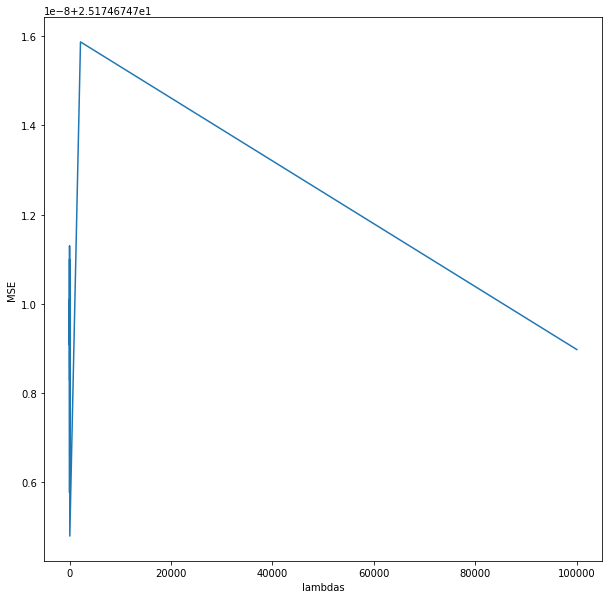

In [286]:
plt.figure(figsize=(10, 10))
plt.plot(lambdas_list, errors)
plt.xlabel('lambdas')
plt.ylabel('MSE')
plt.show()

```3*. Напишите функцию наподобие eval_model_reg2, но для применения L1-регуляризации.```

# L1 регуляризация - Lasso

f(x, W) + (lambda_/2) * np.sum(np.abs(W))

In [287]:
def gradient_descent_alpha_div_i_reg1(X, y, start_alpha, epsilon, lambda_):
    lambda_=1e-8
    n = X.shape[1]
    W = np.random.randn(X.shape[0])
    i=1
    W_prev = np.array([])
    err_prev = 0
    err = 0
    errors = []
    while True:
        W_prev = W.copy()
        err_prev = err
        y_pred = np.dot(W, X)
        err = calc_mse(y, y_pred)
        W -= start_alpha/i * (1/n * 2 * np.dot(X, (y_pred - y))+ lambda_ * np.sign(W)) 
        errors.append(err)
        #if i % 10 == 0:
            #print(i, start_alpha/i, W, err)
        if np.sum(np.abs(W - W_prev)) < epsilon:
            break
        i+=1
    #print(f"для заданной точности {epsilon}\nоптимальное количество итераций = {i-1}\nпри них получаем W = {W_prev} и mse = {err_prev}")
    return W_prev, err_prev

In [288]:
gradient_descent_alpha_div_i_reg1(X_stand, y, start_alpha=1, epsilon = 0.00001, lambda_=1e-5)

(array([1.05877393e-02, 4.72528395e+01, 1.65483519e+00]), 25.174674711863076)

In [289]:
#попробуем разные лямбды
lambdas_list = np.logspace(-10, 1, 10)
errors = []
for i in lambdas_list:
    weight, error = gradient_descent_alpha_div_i_reg1(X_stand, y, start_alpha=1, epsilon = 0.00001, lambda_=1e-4)
    errors.append(error)

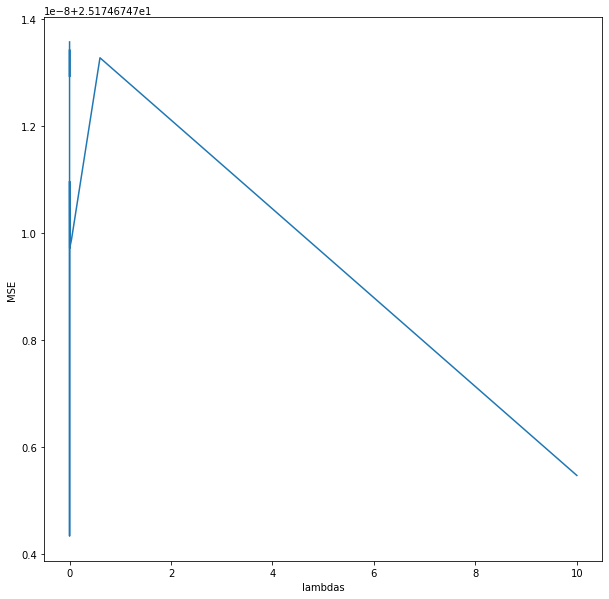

In [290]:
plt.figure(figsize=(10, 10))
plt.plot(lambdas_list, errors)
plt.xlabel('lambdas')
plt.ylabel('MSE')
plt.show()